import


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from PIL import Image

載入mnist

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)



train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38587388.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1114629.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9511178.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3189440.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



設定dip model

In [3]:
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



dip訓練圖片處理

dip訓練設定

In [5]:

dip_epoch = 10
dip_learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 准备输入图像并创建 Deep Image Prior 模型

dip_model = DIP().to(device)

    # 将模型设置为训练模式并进行训练
dip_model.train()

optimizer = optim.Adam(dip_model.parameters(), lr=dip_learning_rate)
loss_fn = nn.MSELoss()
for i in range(dip_epoch):
      for batch_data, _ in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        output = dip_model(batch_data)
        loss = loss_fn(output, batch_data)
        loss.backward()
        optimizer.step()

      print(f"Epoch {i+1}/{dip_epoch}, Loss: {loss.item()}")
initial_prior = output.detach()

torch.save(initial_prior, "initial_prior.pt")


Epoch 1/10, Loss: 0.0024332585744559765
Epoch 2/10, Loss: 0.0011215059785172343
Epoch 3/10, Loss: 0.0007165726274251938
Epoch 4/10, Loss: 0.00046822417061775923
Epoch 5/10, Loss: 0.0004202036652714014
Epoch 6/10, Loss: 0.00031605179538019
Epoch 7/10, Loss: 0.00025192921748384833
Epoch 8/10, Loss: 0.00020884517289232463
Epoch 9/10, Loss: 0.00017707877850625664
Epoch 10/10, Loss: 0.0001340661256108433


設定ddpm參數

In [6]:
batch_size = 128
learning_rate = 0.0001
num_epochs = 50
img_size = 28
timesteps = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

設定U-Net

In [7]:
class UNet(nn.Module):
     def __init__(self):
        super(UNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

     def forward(self, x, t):
        return self.net(x)

model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [8]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.view(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = extract(alphas_cumprod.sqrt(), t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract((1 - alphas_cumprod).sqrt(), t, x_0.shape)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_0, t):
    noise = torch.randn_like(x_0)
    x_noisy = q_sample(x_0, t, noise)
    predicted_noise = denoise_model(x_noisy, t)
    return criterion(predicted_noise, noise)


訓練ddpm

In [9]:
def ddpm_training_step(denoise_model, data, initial_prior, optimizer, criterion, num_steps):
    optimizer.zero_grad()
    t = torch.randint(0, num_steps, (data.size(0),), device=device).long()
    batch_size = data.size(0)

    # 使用批次大小重複 initial_prior
    repeated_prior = initial_prior.repeat(batch_size, 1, 1, 1)[:batch_size]

    x_t = q_sample(repeated_prior, t)

    loss = p_losses(denoise_model, data, t)
    loss.backward()
    optimizer.step()

    return loss.item()



Epoch 1/50, Loss: 0.1207103580236435
Epoch 2/50, Loss: 0.09429830312728882
Epoch 3/50, Loss: 0.08081042766571045
Epoch 4/50, Loss: 0.05756274238228798
Epoch 5/50, Loss: 0.0784127488732338
Epoch 6/50, Loss: 0.04970215633511543
Epoch 7/50, Loss: 0.05392620712518692
Epoch 8/50, Loss: 0.054742567241191864
Epoch 9/50, Loss: 0.06018293276429176
Epoch 10/50, Loss: 0.05620163679122925
Epoch 11/50, Loss: 0.04899394512176514
Epoch 12/50, Loss: 0.05148592218756676
Epoch 13/50, Loss: 0.05193500593304634
Epoch 14/50, Loss: 0.052543818950653076
Epoch 15/50, Loss: 0.051973287016153336
Epoch 16/50, Loss: 0.044115591794252396
Epoch 17/50, Loss: 0.04813205450773239
Epoch 18/50, Loss: 0.04727829247713089
Epoch 19/50, Loss: 0.047740641981363297
Epoch 20/50, Loss: 0.05658808723092079
Epoch 21/50, Loss: 0.047471266239881516
Epoch 22/50, Loss: 0.054366499185562134
Epoch 23/50, Loss: 0.04899170994758606
Epoch 24/50, Loss: 0.045528095215559006
Epoch 25/50, Loss: 0.04640132933855057
Epoch 26/50, Loss: 0.0459918

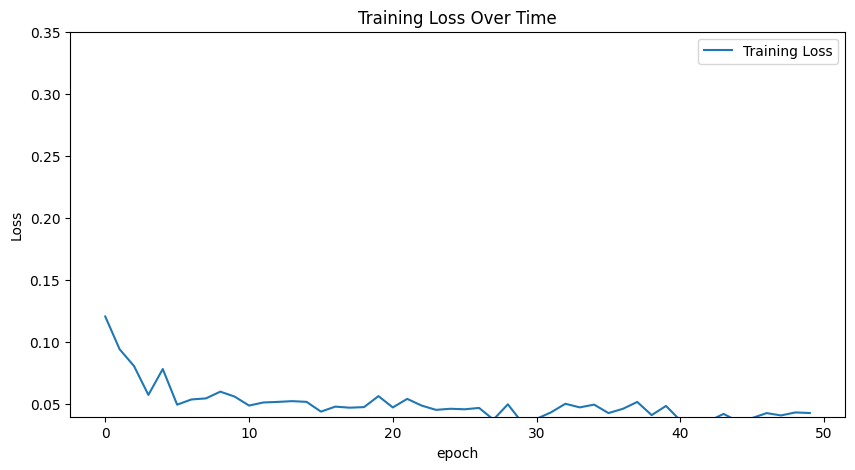

In [10]:
initial_prior = torch.load("initial_prior.pt").to(device)
losses = []

for epoch in range(num_epochs):
    for batch_data, _ in train_loader:
        batch_data = batch_data.to(device)
        loss = ddpm_training_step(model, batch_data, initial_prior, optimizer, criterion, timesteps)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")
    losses.append(loss)
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.ylim(0.04, 0.35)
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


生成圖片

In [40]:
from torchvision.utils import save_image
from google.colab import files
def add_gaussian_noise(image, std_dev):
    noise = np.random.normal(loc=0, scale=std_dev, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# 添加加性高斯雜訊

def save_original_images(images):
    save_image(images, 'original_images.png', nrow=8)
    files.download('original_images.png')

# 儲存生成的圖像函數
def save_generated_images(images):
    save_image(images, 'generated_images.png', nrow=8)
    files.download('generated_images.png')
model.eval()
original_images = next(iter(train_loader))[0][:32].to(device)  # 取出第一個 batch 的原始圖像
noiseimage=add_gaussian_noise(original_images.cpu().numpy() ,3)

noiseimage=torch.from_numpy(noiseimage).to(device).float()
# 生成圖像
with torch.no_grad():
    generated_images = model(noiseimage, torch.full((32,), timesteps-1, dtype=torch.long))
save_original_images(original_images)
save_generated_images(generated_images)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>